In [139]:
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import shap

#Датасет Морское ушко

Определение возраста морского ушка по физическим измерениям. Возраст морского ушка определяется путем разрезания раковины через конус, окрашивания и подсчета количества колец под микроскопом.
----
----

Это скучное и трудоемкое занятие. Для определения возраста используются другие измерения, которые получить проще.
----
----
Из исходных данных были удалены примеры с пропущенными значениями (в большинстве случаев отсутствовало прогнозируемое значение), а диапазоны непрерывных значений были масштабированы для использования в ИНС (путем деления на 200).
----
----

## Описание данных
* `Sex` - категориальный - биологический пол: M, F, and I (infant - младенец)
* `Length` - вещественный, мм - длина вдоль самой длинной оси
* `Diameter` - вещественный, мм - диаметр, перпендикулярен длине
* `Height` - вещественный, мм - высота (с раковиной)
* `Whole_weight` - вещественный, грамм - масса всего морского ушка
* `Shucked_weight` - вещественный, грамм - масса мяса без раковины
* `Viscera_weight` - вещественный, грамм - масса внутренностей (после удаления мяса)
* `Shell_weight` - вещественный, грамм - вес раковины после сушки
* `Rings` - целочисленный - количество колец, +1,5 дает возраст в годах

загрузка данных

In [7]:
ARCHIVE_PATH = '/content/drive/MyDrive/!алгоритмы_понижения_размерности/abalone.zip'

with zipfile.ZipFile(ARCHIVE_PATH, 'r') as zip_ref:
    zip_ref.extractall()

In [8]:
columns_names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']

df = pd.read_csv('/content/abalone.data', names=columns_names)

In [ ]:
df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### Кол-во образов, пропуски
----
В датасете 4177 измерений, пропусков в каком либо столбце нет

----

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


### Основные числовые характеристики
----
числовых признаков - 8/9 (включая целевой признак rings)

----

In [ ]:
df.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


### Категориальные характеристики
----

категориальных признаков 1/9

----

In [ ]:
df.describe(include='object')

,Sex
count,4177
unique,3
top,M
freq,1528


### Дубликаты
----

дубликатов строк в датасете нет

----

In [9]:
df.duplicated().sum()

np.int64(0)

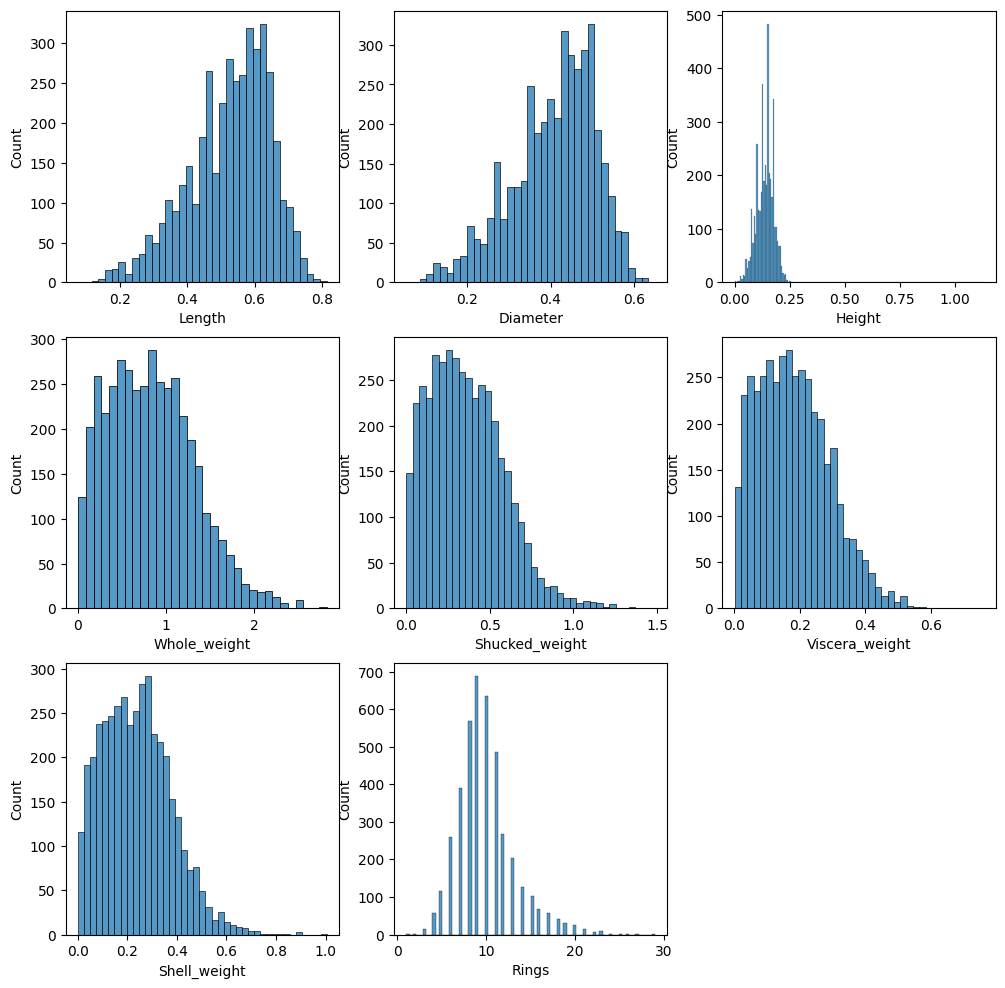

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))


for ind_, col in  zip(axes.reshape(9)[:-1], df.columns[1:]):
    sns.histplot(df[col], ax=ind_)
axes[2, 2].set_visible(False)



## Однофакторный анализ

### Sex

----
Количество объектов разных полов примерно сбалансировано, male больше остальных на 4-5 %

----


In [ ]:
df['Sex'].value_counts(normalize=True)

,proportion
Sex,
M,0.365813
I,0.321283
F,0.312904


----
Среднее количество колец у особей-младенцев (I) меньше, чем у остальных.

----
Больше всех колец у самок (F)

----


/tmp/ipython-input-1830076787.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='Rings', data=df, palette='autumn')


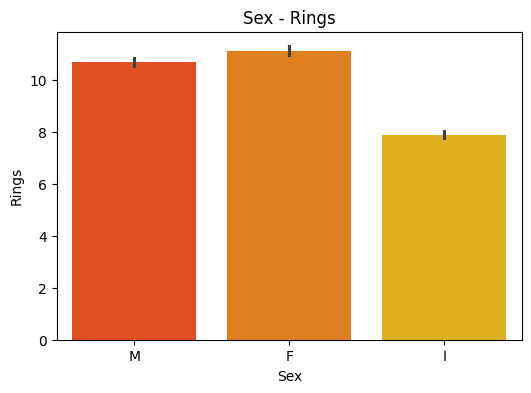

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x='Sex', y='Rings', data=df, palette='autumn')
plt.title('Sex - Rings')
plt.show();

----
Но и среди младенцев(I) есть особи с большим количеством колец (21), и среди F и M есть небольшое кол-во колец 5, 3

----

In [ ]:
df.groupby('Sex').agg(
    RingsMean = ('Rings', 'mean'),
    RingsStd = ('Rings', 'std'),
    RingsMax = ('Rings', 'max'),
    RingsMin = ('Rings', 'min'),
)

,RingsMean,RingsStd,RingsMax,RingsMin
Sex,,,,
F,11.129304,3.104256,29,5
I,7.890462,2.511554,21,1
M,10.705497,3.026349,27,3


----
Основаня часть самцов и самок находится в диапазоне 7-15 колец.

----
Основная часть младенцев в диапазоне 4-12 колец

----


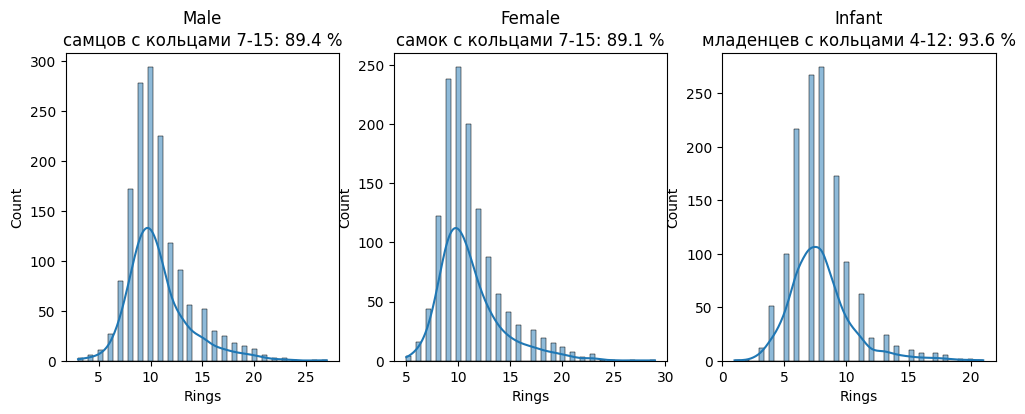

In [ ]:
male_count = \
    len(
        df[(df['Sex'] == 'M')
        & (df['Rings'] >=7)
        & (df['Rings'] <= 15)]
        ) \
    / len(df[df['Sex'] == 'M']) \
    * 100

female_count = \
    len(
        df[(df['Sex'] == 'F')
        & (df['Rings'] >=7)
        & (df['Rings'] <= 15)]
        ) \
    / len(df[df['Sex'] == 'F']) \
    * 100

infant_count = \
    len(
        df[(df['Sex'] == 'I')
        & (df['Rings'] >=4)
        & (df['Rings'] <= 12)]
        ) \
    / len(df[df['Sex'] == 'I']) \
    * 100

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.histplot(df['Rings'][df['Sex'] == 'M'], ax=axes[0], bins=50, kde=True)
axes[0].set_title(f'Male\nсамцов с кольцами 7-15: {male_count:.1f} %')

sns.histplot(df['Rings'][df['Sex'] == 'F'], ax=axes[1], bins=50, kde=True)
axes[1].set_title(f'Female\nсамок с кольцами 7-15: {female_count:.1f} %')

sns.histplot(df['Rings'][df['Sex'] == 'I'], ax=axes[2], bins=50, kde=True)
axes[2].set_title(f'Infant\nмладенцев с кольцами 4-12: {infant_count:.1f} %')

plt.show()

### Length и Diameter

----
распределение с отрицательным перекосом

----

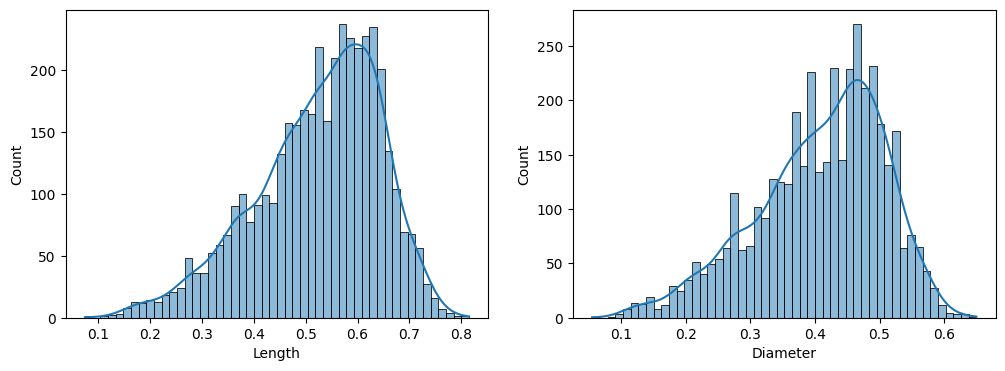

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df['Length'], bins=50, kde=True, ax=axes[0])
sns.histplot(df['Diameter'], bins=50, kde=True, ax=axes[1])
plt.show()

----
объекты с самыми большими и малыми длинами и их диаметры

----


In [ ]:
df[['Length', 'Diameter']][df['Length'] == df['Length'].max()]

,Length,Diameter
1428,0.815,0.65


In [ ]:
df[['Length', 'Diameter']][df['Length'] == df['Length'].min()]

,Length,Diameter
236,0.075,0.055


----
зависимость количества колец от длины и диаметра ближе всего к линейной

----

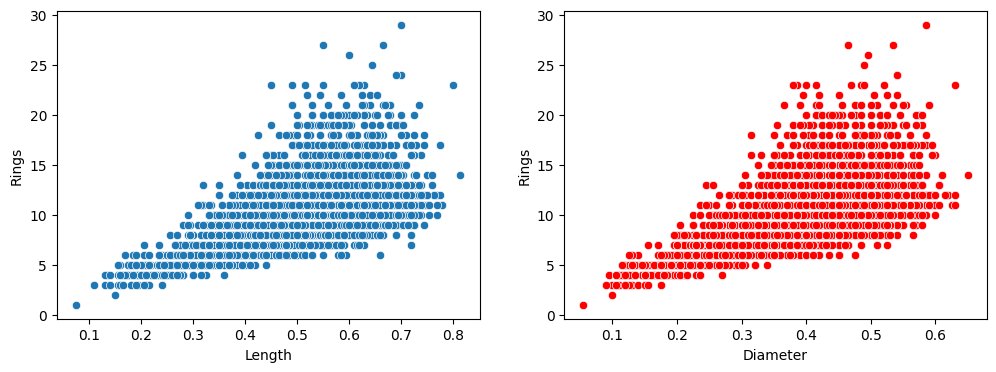

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(x='Length', y='Rings', data=df, ax=axes[0])
sns.scatterplot(x='Diameter', y='Rings', data=df, ax=axes[1], color='r')
plt.show()

----
зависимость веса объектов от длины и диаметра ближе к полиномиальной

----

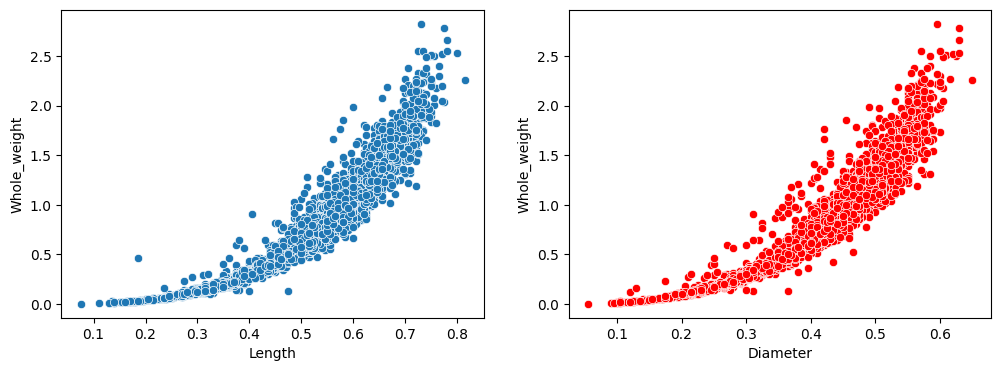

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(x='Length', y='Whole_weight', data=df, ax=axes[0])
sns.scatterplot(x='Diameter', y='Whole_weight', data=df, ax=axes[1], color='r')
plt.show()

----
средние размеры у объектов-младенцев меньше чем у male, female

----

In [ ]:
df.groupby('Sex').agg(
    LengthMean = ('Length', 'mean'),
    DiameterMean = ('Diameter', 'mean')
)

,LengthMean,DiameterMean
Sex,,
F,0.579093,0.454732
I,0.427746,0.326494
M,0.561391,0.439287


### Height

----
длинный хвост из нескольких больших значений

----

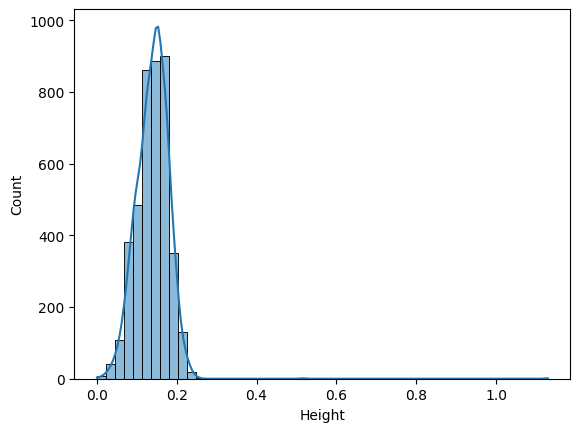

In [ ]:
sns.histplot(df['Height'], bins=50, kde=True)
plt.show()

----
распределение без значений выше 0.25 ближе к нормальному

----

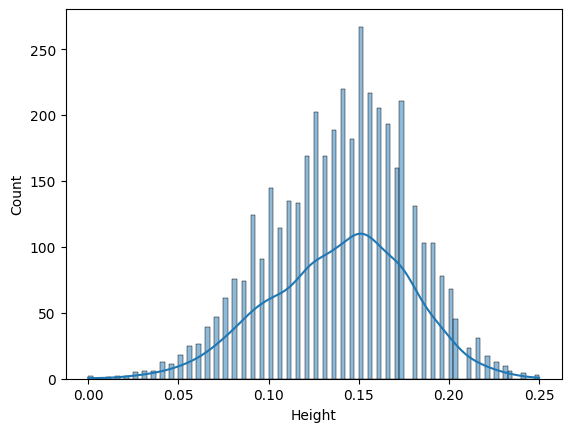

In [ ]:
sns.histplot(df['Height'][df['Height'] <= 0.25], bins=100, kde=True)
plt.show()

----
значений больше 0.25 мм всего два и они сильно выбиваются на общем фоне

----

In [ ]:
df[df['Height'] > 0.25]

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
1417,M,0.705,0.565,0.515,2.210,1.1075,0.4865,0.5120,10
2051,F,0.455,0.355,1.130,0.594,0.3320,0.1160,0.1335,8


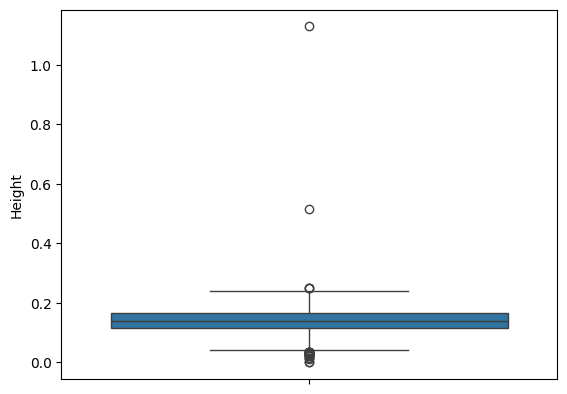

In [ ]:
sns.boxplot(df['Height'])
plt.show()

----
эти два значение не влияют ни на вес объектов, ни на кол-во колец

----
также они не связаны с остальными размерами объекта

----

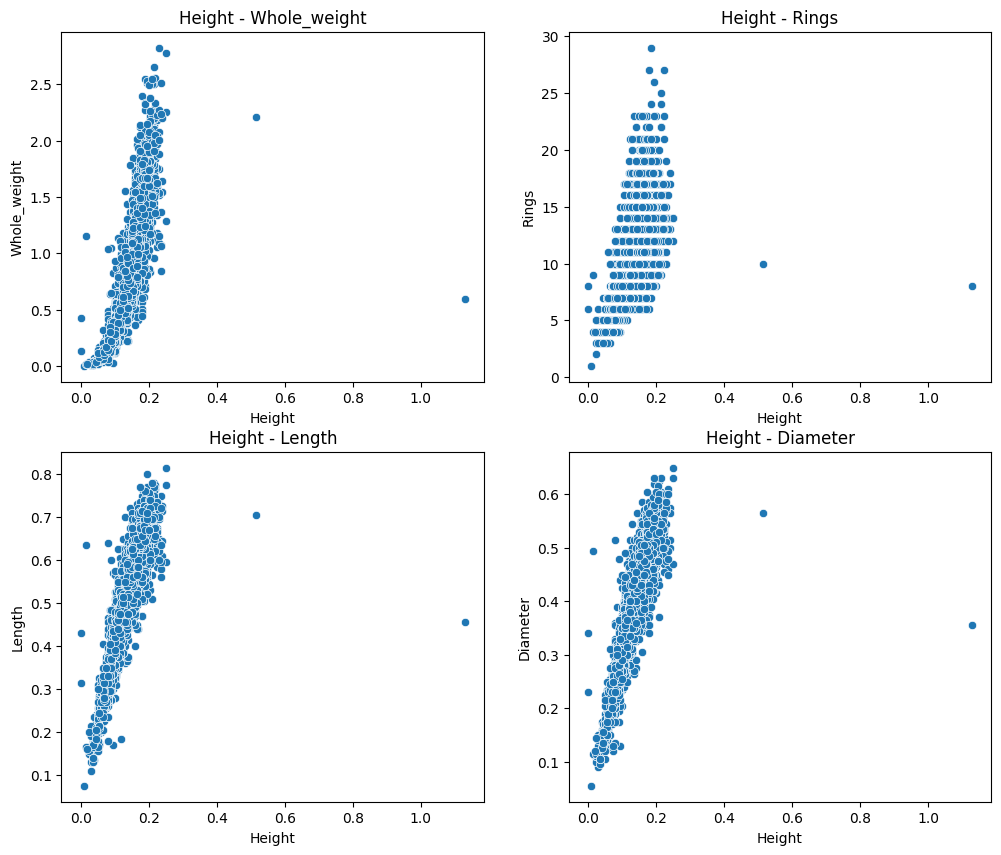

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.scatterplot(x='Height', y='Whole_weight', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Height - Whole_weight')
sns.scatterplot(x='Height', y='Rings', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Height - Rings')
sns.scatterplot(x='Height', y='Length', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Height - Length')
sns.scatterplot(x='Height', y='Diameter', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Height - Diameter')

plt.show()

----
удаление Height > 0.25

----

In [10]:
print('кол-во элементов до удаления:', len(df))
print('удаление индексов:', df[(df['Height'] > 0.25)].index)
df.drop(df[(df['Height'] > 0.25)].index, inplace=True)
print('кол-во элементов после удаления:', len(df))

кол-во элементов до удаления: 4177
удаление индексов: Index([1417, 2051], dtype='int64')
кол-во элементов после удаления: 4175


----
Минимальное значение Height - 0, объектов с такми значением всего 2

----

In [ ]:
df['Height'].min()

0.0

In [ ]:
df[(df['Height'] == df['Height'].min())]

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


----
Удалим 2 объекта с этим значением

----

In [11]:
print('кол-во элементов до удаления:', len(df))
print('удаление индексов:', df[(df['Height'] == 0)].index)
df.drop(df[(df['Height'] == 0)].index, inplace=True)
print('кол-во элементов после удаления:', len(df))

кол-во элементов до удаления: 4175
удаление индексов: Index([1257, 3996], dtype='int64')
кол-во элементов после удаления: 4173


In [12]:
df.reset_index(inplace=True, drop=True)

### Whole_weight,	Shucked_weight,	Viscera_weight,	Shell_weight

----
у всех масс положительный перекос

----

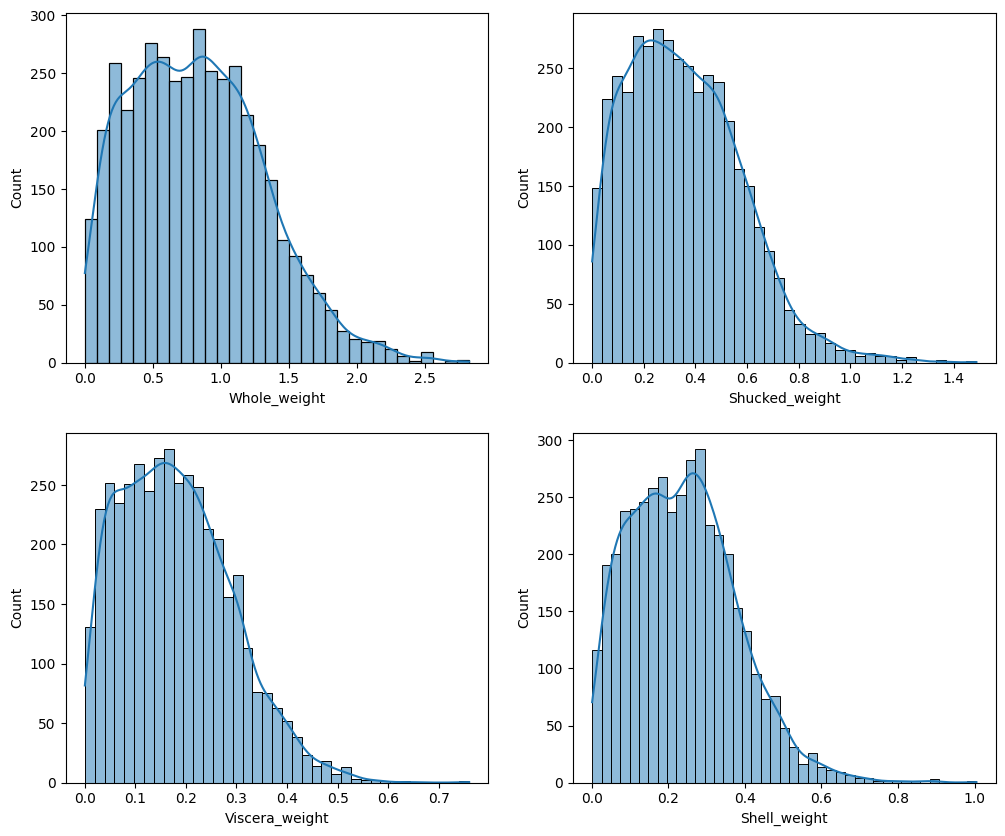

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(df['Whole_weight'], kde=True, ax=axes[0,0])

sns.histplot(df['Shucked_weight'], kde=True, ax=axes[0,1])

sns.histplot(df['Viscera_weight'], kde=True, ax=axes[1,0])

sns.histplot(df['Shell_weight'], kde=True, ax=axes[1,1])


plt.show()

In [ ]:
df[['Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']].describe()

,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
count,4173.000000,4173.000000,4173.000000,4173.000000
mean,0.828730,0.359304,0.180595,0.238794
std,0.489987,0.221705,0.109525,0.139172
min,0.002000,0.001000,0.000500,0.001500
25%,0.442000,0.186000,0.093500,0.130000
50%,0.800000,0.336000,0.171000,0.234000
75%,1.153000,0.502000,0.253000,0.328500
max,2.825500,1.488000,0.760000,1.005000


----
минимальные веса принадлежат одному объекту

----

In [ ]:
df[
    (df['Whole_weight'] == df['Whole_weight'].min())
    | (df['Shucked_weight'] == df['Shucked_weight'].min())
    | (df['Viscera_weight'] == df['Viscera_weight'].min())
    | (df['Shell_weight'] == df['Shell_weight'].min())
    ]

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
236,I,0.075,0.055,0.01,0.0020,0.0010,0.0005,0.0015,1
3522,I,0.240,0.185,0.06,0.0655,0.0295,0.0005,0.0200,4


----
максимальные четырем разным объектам

----

In [ ]:
df[
    (df['Whole_weight'] == df['Whole_weight'].max())
    | (df['Shucked_weight'] == df['Shucked_weight'].max())
    | (df['Viscera_weight'] == df['Viscera_weight'].max())
    | (df['Shell_weight'] == df['Shell_weight'].max())
    ]

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
163,F,0.725,0.560,0.210,2.1410,0.6500,0.3980,1.005,18
891,M,0.730,0.595,0.230,2.8255,1.1465,0.4190,0.897,17
1209,F,0.780,0.630,0.215,2.6570,1.4880,0.4985,0.586,11
1763,M,0.775,0.630,0.250,2.7795,1.3485,0.7600,0.578,12


----
Наибольшая корреляция количества колец с массой раковины

----

In [ ]:
weights_corr = {
    'Whole_weight': np.corrcoef(df['Rings'], df['Whole_weight'])[0][1],
    'Shucked_weight': np.corrcoef(df['Rings'], df['Shucked_weight'])[0][1],
    'Viscera_weight': np.corrcoef(df['Rings'], df['Viscera_weight'])[0][1],
    'Shell_weight': np.corrcoef(df['Rings'], df['Shell_weight'])[0][1]
}

print('Корреляция Rings с:')

for k, v in weights_corr.items():
    print(f'{k}: {v:.2f}')


Корреляция Rings с:
Whole_weight: 0.54
Shucked_weight: 0.42
Viscera_weight: 0.50
Shell_weight: 0.63


----
зависимость Rings от Shell_weight

----

<Axes: xlabel='Shell_weight', ylabel='Rings'>

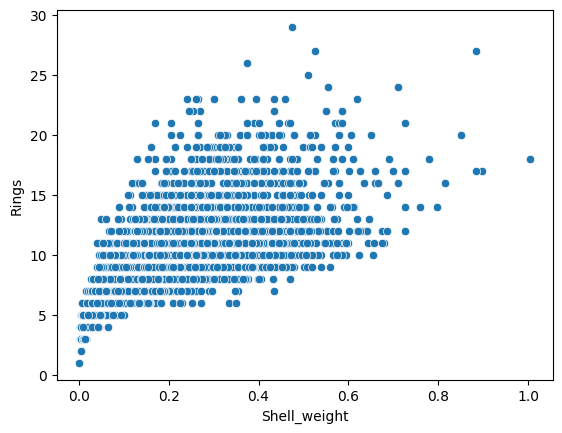

In [ ]:
sns.scatterplot(x='Shell_weight', y='Rings', data=df)

----
средние значения всех масс у объектов-младенцев более чем в 2 раза меньше по сравнению с male, female

----

In [ ]:
df.groupby('Sex').agg(
    WholeWeightMean = ('Whole_weight', 'mean'),
    ShuckedWeightMean = ('Shucked_weight', 'mean'),
    VisceraWeightMean = ('Viscera_weight', 'mean'),
    ShellWeightMean = ('Shell_weight', 'mean'),
)

,WholeWeightMean,ShuckedWeightMean,VisceraWeightMean,ShellWeightMean
Sex,,,,
F,1.046879,0.446275,0.230776,0.302139
I,0.431587,0.191123,0.092062,0.128026
M,0.990661,0.432504,0.215367,0.281819


## Кодирование категорий

----
Среди категориальных признаков есть только пол (Sex)

----
Sex - номинальный признак, и, чтобы не вводить искусственный порядок, при кодировании используем one hot encoder  

----

In [13]:
df_encoded = df.copy()

In [14]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

one_hot_encoded = encoder.fit_transform(df_encoded[['Sex']])

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['Sex']))

df_encoded = pd.concat([df_encoded, one_hot_df], axis=1)

In [15]:
df_encoded

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_F,Sex_I,Sex_M
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,0.0,0.0,1.0
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,0.0,0.0,1.0
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,1.0,0.0,0.0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,0.0,0.0,1.0
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4168,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,1.0,0.0,0.0
4169,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,0.0,0.0,1.0
4170,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,0.0,0.0,1.0
4171,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,1.0,0.0,0.0


In [17]:
df_encoded = df_encoded.drop(['Sex'], axis=1)

## Взаимозависимость данных

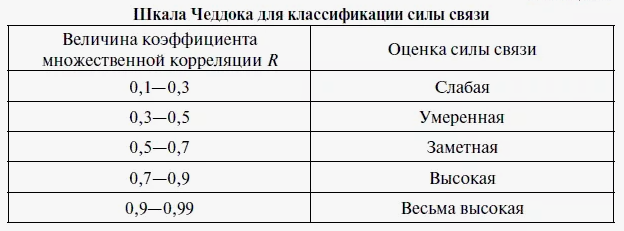

----
По спирмену имеется заметная монотонная связь Rings с признаками размерами и массами

----
По пирсону коэффициенты корреляции меньше, но линейная связь также попадает в диапазон заметных

----
По Кендаллу коэффициенты корреляции еще меньше, но порядковая связь попадает в диапазон умеренных

----

### Корреляция Пирсона

<Axes: >

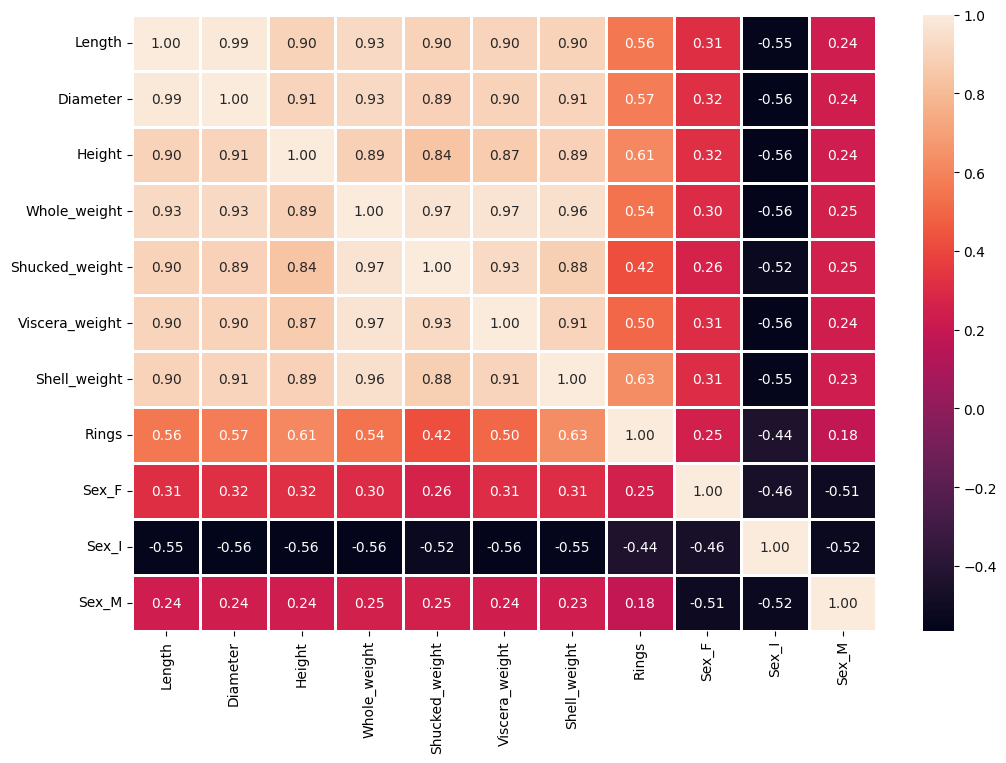

In [39]:
corr = df_encoded.corr() # матрица корреляций

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt='.2f', linewidth=1)

----
У Rings заметная (0.5-0.7) линейная связь  со всеми признаками-размерами и с массами (ракушки, общей и внутренностей):

----

In [40]:
corr.loc['Rings',:].abs()[(corr.loc['Rings',:] >= 0.5) & (corr.loc['Rings',:] < 1)].sort_values(ascending=False)

,Rings
Shell_weight,0.628169
Height,0.610107
Diameter,0.574551
Length,0.556572
Whole_weight,0.540621
Viscera_weight,0.503977


### Корреляция Спирмена

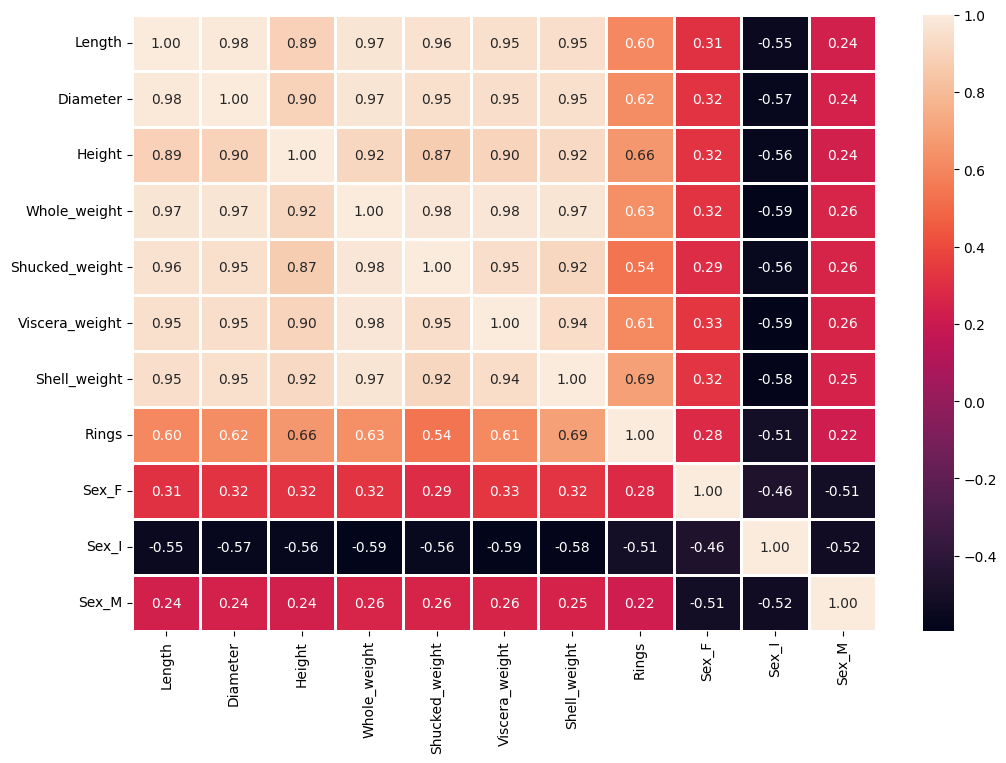

In [43]:
corr = df_encoded.corr(method='spearman')

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt='.2f', linewidth=1);

----
У Rings заметная (0.5-0.7) монотонная связь  со всеми признаками-размерами и со всеми массами

----
Также заметная обратная монотонная связь с полом младенцев

----

In [45]:
corr.loc['Rings',:][(corr.loc['Rings',:].abs() >= 0.5) & (corr.loc['Rings',:] < 1)].sort_values(ascending=False, key=(lambda x: abs(x)))

,Rings
Shell_weight,0.693018
Height,0.658139
Whole_weight,0.630489
Diameter,0.622477
Viscera_weight,0.613942
Length,0.603924
Shucked_weight,0.539061
Sex_I,-0.507171


### Корреляция Кендалла

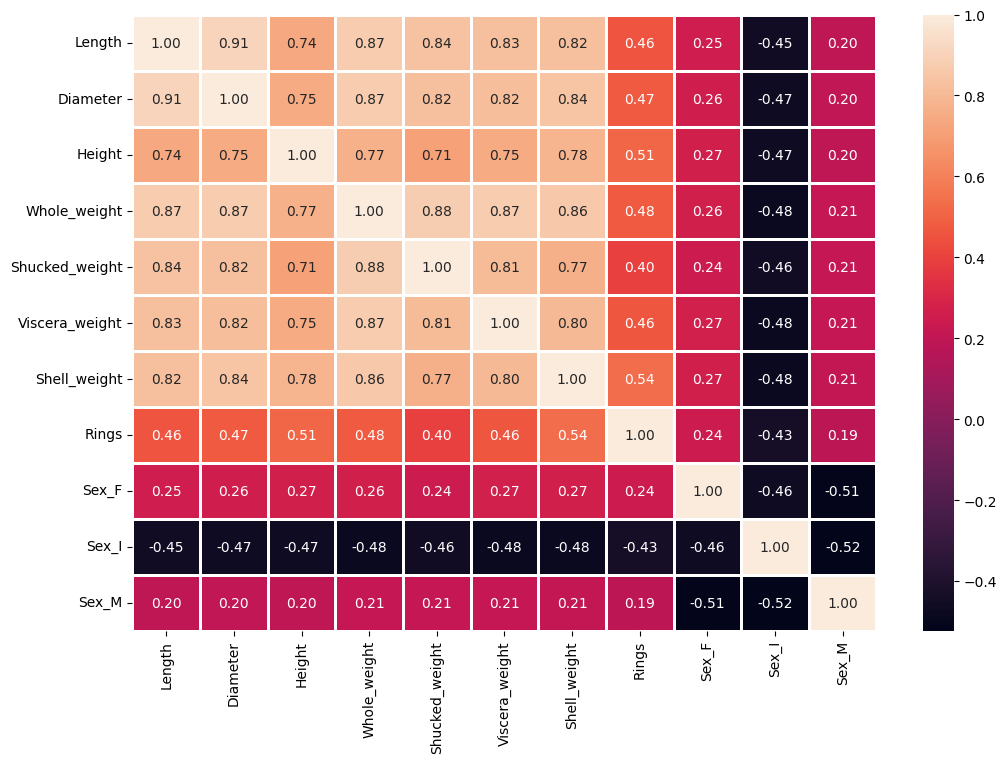

In [46]:
corr = df_encoded.corr(method='kendall')

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt='.2f', linewidth=1);

----
У Rings заметная порядковая связь  только с массой раковины и с высотой ракушки

----


In [47]:
corr.loc['Rings',:][(corr.loc['Rings',:].abs() >= 0.5) & (corr.loc['Rings',:] < 1)].sort_values(ascending=False, key=(lambda x: abs(x)))

,Rings
Shell_weight,0.535069
Height,0.509826


----
С остальными размерами и массами порядковая связь умеренная

----

In [48]:
corr.loc['Rings',:][(corr.loc['Rings',:].abs() >= 0.3) & (corr.loc['Rings',:] < 0.5)].sort_values(ascending=False, key=(lambda x: abs(x)))

,Rings
Whole_weight,0.476072
Diameter,0.473744
Viscera_weight,0.461005
Length,0.456884
Sex_I,-0.434615
Shucked_weight,0.398840


## Модели

----
В качестве моделей используем ансамбль деревьев RandomForest и линейную Ridge (для устранения мультиколлинеарности признаков в лин. модели) и сравним их результаты

----


In [58]:
X = df_encoded.drop(columns=['Rings'])
y = df_encoded['Rings']

### Permutation Importance

----
Для обеих моделей наиболее важными признаками являются все массы объектов

----

----
Для RandomForest c n_escimators=100 наиболее значимые параметры это масса раковины и масса мяса ракушки

----

In [74]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=43)
random_forest.fit(X, y)

res_rand_forest = permutation_importance(random_forest, X, y, n_repeats=10, n_jobs=-1, random_state=35)

print(f'{'Feature':^15}:{'Importance':^16}\n')
ir = res_rand_forest.importances_mean.argsort()[::-1]
for i in ir:
  print(f'{X.columns[i]:<15}: {res_rand_forest.importances_mean[i]:.3f} std {res_rand_forest.importances_std[i]:.3f}\n')

    Feature    :   Importance   

Shell_weight   : 1.852 std 0.026

Shucked_weight : 1.077 std 0.016

Whole_weight   : 0.231 std 0.004

Viscera_weight : 0.145 std 0.002

Height         : 0.145 std 0.003

Diameter       : 0.098 std 0.002

Length         : 0.092 std 0.002

Sex_I          : 0.067 std 0.002

Sex_F          : 0.008 std 0.000

Sex_M          : 0.008 std 0.000



----
Для Ridge с alpha=1.0 наиболее значимые параметры это масса мяса ракушки и общая масса

----

In [72]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_regres = Ridge(alpha=1.0)
lin_regres.fit(X_scaled, y)

res_lin_reg = permutation_importance(lin_regres, X_scaled, y, n_repeats=10, n_jobs=-1, random_state=35)
print(f'{'Feature':^15}:{'Importance':^16}\n')
ir = res_lin_reg.importances_mean.argsort()[::-1]
for i in ir:
  print(f'{X.columns[i]:<15}: {res_lin_reg.importances_mean[i]:.3f} std {res_lin_reg.importances_std[i]:.3f}\n')

    Feature    :   Importance   

Shucked_weight : 3.428 std 0.067

Whole_weight   : 3.343 std 0.073

Viscera_weight : 0.269 std 0.007

Shell_weight   : 0.247 std 0.008

Height         : 0.158 std 0.006

Diameter       : 0.157 std 0.005

Sex_I          : 0.013 std 0.001

Sex_M          : 0.005 std 0.001

Length         : 0.003 std 0.001

Sex_F          : 0.002 std 0.001



### Обучение

----
Для стратификации Rings разделим этот признак на 3 группы (меньше 8 колец, от 8 до 10 колец, и больше 10 колец)

----

In [97]:
bins = [0, 8, 10, np.inf]
y_bins = pd.cut(y, bins=bins)  # 10 квантилей
y_bins.value_counts()

,count
Rings,
"(10.0, inf]",1447
"(0.0, 8.0]",1404
"(8.0, 10.0]",1322


#### RandomForest со всеми признаками

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y_bins)

----
кросс-валидация по n_estimators и max_depth c метрикой mse

----

In [212]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}
grid_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
print('Оптимальные параметры:\n',grid_rf.best_params_)

Оптимальные параметры:
 {'max_depth': 10, 'n_estimators': 200}


----
Обучение с оптимальными параметрами

----

In [213]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

res_metrics = {
    'mape': [mean_absolute_percentage_error(y_test, y_pred)],
    'mse': [mean_squared_error(y_test, y_pred)],
    'model': ['RandomForestRegressor'],
    'features': ['all']}

----
создание shap explainer для демонстрации работы

----

In [214]:
rf_full_explainer = shap.Explainer(rf_model)
rf_full_shap_values = rf_full_explainer(X_test)
shap.initjs()

#### RandomForest с признаками Shell_weight, Shucked_weight

----
кросс-валидация по n_estimators и max_depth c метрикой mse

----

In [215]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}
grid_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_rf.fit(X_train[['Shell_weight', 'Shucked_weight']], y_train)
print('Оптимальные параметры:\n',grid_rf.best_params_)

Оптимальные параметры:
 {'max_depth': 10, 'n_estimators': 200}


----
Обучение с оптимальными параметрами

----

In [216]:
rf_model_2 = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf_model_2.fit(X_train[['Shell_weight', 'Shucked_weight']], y_train)
y_pred = rf_model_2.predict(X_test[['Shell_weight', 'Shucked_weight']])

res_metrics['mape'].append(mean_absolute_percentage_error(y_test, y_pred))
res_metrics['mse'].append(mean_squared_error(y_test, y_pred))
res_metrics['model'].append('RandomForestRegressor')
res_metrics['features'].append('Shell_weight, Shucked_weight')

----
создание shap explainer для демонстрации работы

----

In [217]:
rf_2_explainer = shap.Explainer(rf_model_2)
rf_2_shap_values = rf_2_explainer(X_test[['Shell_weight', 'Shucked_weight']])

#### Ridge со всеми признаками

In [218]:
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
X_s_train, X_s_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y_bins)

----
кросс-валидация по alpha c метрикой mse

----

In [219]:
grid_ridge = RidgeCV(
    alphas=[0.01, 0.1, 1, 10, 100],
    cv=5,
    scoring='neg_mean_squared_error'
)

grid_ridge.fit(X_s_train, y_train)

print('Оптимальный alpha: ', grid_ridge.alpha_)

Оптимальный alpha:  1.0


----
Обучение с оптимальными параметрами

----

In [220]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_s_train, y_train)
y_pred = ridge_model.predict(X_s_test)

res_metrics['mape'].append(mean_absolute_percentage_error(y_test, y_pred))
res_metrics['mse'].append(mean_squared_error(y_test, y_pred))
res_metrics['model'].append('Ridge')
res_metrics['features'].append('all')

----
создание shap explainer для демонстрации работы

----

In [224]:
ridge_full_explainer = shap.Explainer(ridge_model, X_s_train)
ridge_full_shap_values = ridge_full_explainer(X_s_test)

#### Ridge с признаками Shucked_weight, Whole_weight

----
кросс-валидация по alpha c метрикой mse

----

In [221]:
grid_ridge = RidgeCV(
    alphas=[0.01, 0.1, 1, 10, 100],
    cv=5,
    scoring='neg_mean_squared_error'
)

grid_ridge.fit(X_s_train[['Shucked_weight', 'Whole_weight']], y_train)

print('Оптимальный alpha:', grid_ridge.alpha_)

Оптимальный alpha: 0.1


----
Обучение с оптимальными параметрами

----

In [222]:
ridge_model_2 = Ridge(alpha=0.1)
ridge_model_2.fit(X_s_train[['Shucked_weight', 'Whole_weight']], y_train)
y_pred = ridge_model_2.predict(X_s_test[['Shucked_weight', 'Whole_weight']])

res_metrics['mape'].append(mean_absolute_percentage_error(y_test, y_pred))
res_metrics['mse'].append(mean_squared_error(y_test, y_pred))
res_metrics['model'].append('Ridge')
res_metrics['features'].append('Shucked_weight, Whole_weight')

----
создание shap explainer для демонстрации работы

----

In [225]:
ridge_2_explainer = shap.Explainer(ridge_model_2, X_s_train[['Shucked_weight', 'Whole_weight']])
ridge_2_shap_values = ridge_2_explainer(X_s_test[['Shucked_weight', 'Whole_weight']])

## Результаты

----
по MAPE результаты почти одинаковые.

----
По обоим метрикам (MAPE и MSE) RandomForest выдает меньшую ошибку чем Ridge.

----
Также для каждой модели (RandomForest и Ridge) лучшие результаты при обучении на полном наборе признаков.

----

In [226]:
df_rez_metrics = pd.DataFrame(res_metrics)
df_rez_metrics['mape'] = df_rez_metrics['mape'].apply(lambda x: f'{x * 100:.2f} %')
df_rez_metrics.sort_values(by='mape', ascending=True)

,mape,mse,model,features
0,15.14 %,4.437332,RandomForestRegressor,all
1,16.18 %,4.893627,RandomForestRegressor,"Shell_weight, Shucked_weight"
2,16.25 %,4.674526,Ridge,all
3,18.31 %,5.402283,Ridge,"Shucked_weight, Whole_weight"


### Сводный анализ RandomForest

----
1. Масса раковины Shell_weight оказывает влияние на наибольшее количество объектов. Причем как и высокая масса повышает количество колец, так и низкая масса значительно уменьшает количество (по вытянутой в обе стороны шкале).

----
2. Масса мяса Shucked_weight на втором месте по влиянию. Высокое значение уменьшает количество колец, но не так значительно как предыдущий признак (шкала уже). Низкая масса неоднозначно влияет на кольца объектов (цвета синих точек перемешаны с более светлыми), значит признак влияет на рост колец совместно с другими.

----
3. Общая масса Whole_weight на третьем месте по влиянию, высокие значения влияют на рост количества колец, но в меньшей степени чем предыдущие признаки выше.

----
4. Положительные и отрицательные значения пола младенец (infant) Sex_I тоже оказывают небольшое влияние на падение, рост количества колец соответственно.

----
5. Остальные признаки оказывают небольшое влияние на рост количества колец. Самое незначительное - пол самца и самки(Sex_F, Sex_M)

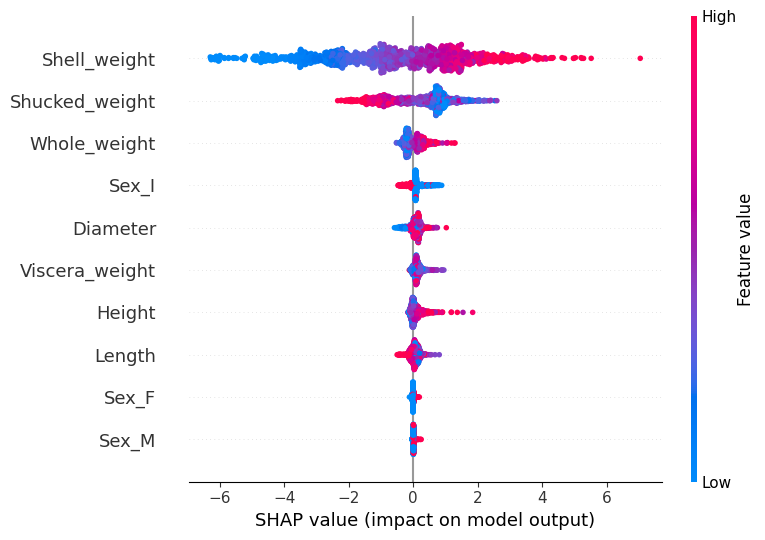

In [227]:
shap.summary_plot(rf_full_shap_values, X_test)

## Сводный анализ Ridge

1. Самый влиятельный признак это масса мяса, оказывает обратное влияние на количество колец, как у модели RandomForest, но более значительное - высокие значения массы уменьшают количество колец.
2. На втором месте общая масса Whole_weight, которая, как и в модели RandomForest, прямо влияет на рост колец, новысокие значения массы больше влияют на рост количества колец.
3. Следующие признаки связанные с массой и размером оказывают не такое значительное влияние на рост колец, как предыдущие, но оно все равно весомое.
4. Признаки пола почти не влияют на количество колец

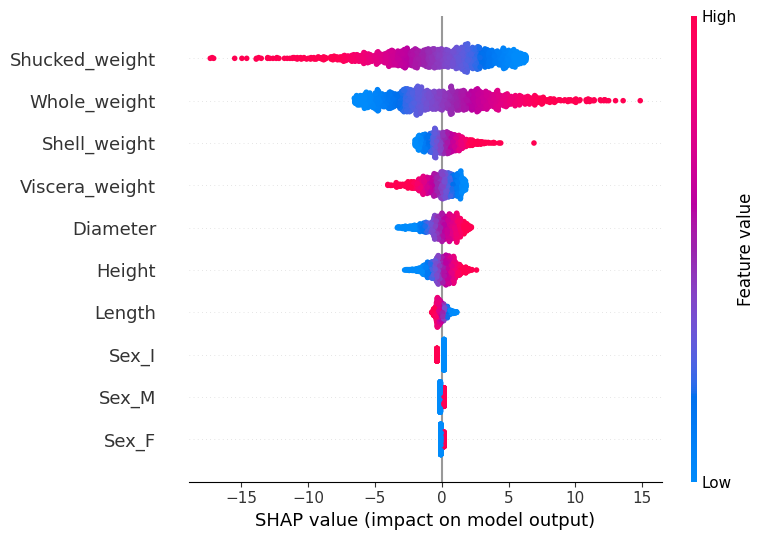

In [229]:
shap.summary_plot(ridge_full_shap_values, X_s_test)